# Telelog data forecasting with ARIMA model

In this notebook, we are trying to build up a Time Series Model to forecast the Telelog data ingestion. By visualization and comparing the observed real data curve & forecast curve, it is intuitive to identify the new coming data is in normal/abnormal pattern.   
It is an extended functionality in the "Telelog data ingestion monitoring" project, more background and details for that project please refer `README.md` in the repository. 

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import itertools
import statsmodels.api as sm
from datetime import datetime, timedelta
from matplotlib.ticker import FuncFormatter
from spillway import Spill

# Defaults
plt.rcParams['figure.figsize'] = (20, 8)
plt.style.use('ggplot')

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## Step 1 - Data preparation and visualization

In [ ]:
# An ODBC data source needs to be created beforehand to connect to the data lake PRD system.
spw = Spill(dsn='mbc_datalake_prod')

In [2]:
# Acquire one year data to have an overall picture
dt = datetime.today() - timedelta(days=365)

query = """
SELECT dd, hour(ts) as day_hour, 
count(*) as num_records, 
count(distinct uuid) as num_sessions, 
count(distinct vin) as num_vins
FROM datalake_telelog.dw_telelog
WHERE dd >= '{}'
GROUP BY dd, hour(ts)
ORDER BY dd, day_hour ASC
""".format(dt.strftime('%Y-%m-%d'))

Note: Acquiring data through ODBC takes long time, so we suggest to save the result for each query.

In [29]:
df = spw.execute(query)
df.to_csv('../data/telelog_{}.csv'.format(datetime.today().strftime('%Y-%m-%d')))

In [3]:
df = pd.read_csv('../data/telelog_2018-08-02.csv')

In [4]:
# Convert to type datetime
df['dt'] = df.apply(lambda r: pd.to_datetime('{} {}:00:00'.format(r['dd'], r['day_hour'])), axis=1)
print(df['dt'].max())

2018-08-02 00:00:00


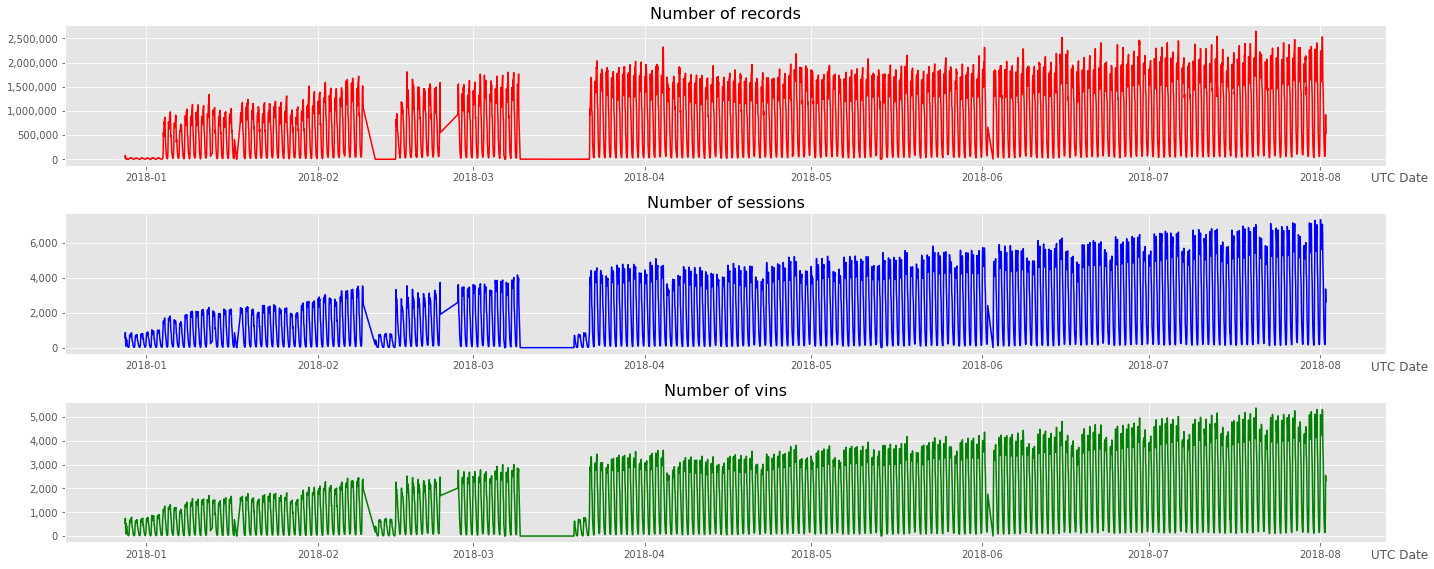

In [5]:
# Plot and save images
fig = plt.figure(figsize=(20,8))
ax1 = fig.add_subplot(311)
ax1.get_yaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
ax1.set_title('Number of records', fontsize=16)
ax1.xaxis.set_label_coords(1.01, -0.045)
plt.xlabel('UTC Date')
plt.plot(df.dt, df.num_records, 'r-')
ax2 = fig.add_subplot(312)
ax2.get_yaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
ax2.set_title('Number of sessions', fontsize=16)
ax2.xaxis.set_label_coords(1.01, -0.045)
plt.xlabel('UTC Date')
plt.plot(df.dt, df.num_sessions, 'b-')
ax3 = fig.add_subplot(313)
ax3.get_yaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
ax3.set_title('Number of vins', fontsize=16)
ax3.xaxis.set_label_coords(1.01, -0.045)
plt.xlabel('UTC Date')
plt.plot(df.dt, df.num_vins, 'g-')
plt.tight_layout()

img = '../image/{}.png'.format(datetime.today().strftime('%Y-%m-%d'))
fig.savefig(img)

### Short conclusion: 

* Telelog time series has an obvious seasonality pattern, with an overall slight increasing trend (We will also plot a more clear figure in Step 3 by decomposing our time series into three distinct components: trend, seasonality, and noise).
* The data in 2018 Q1 is not stable/continuous, which will be excluded for further analysis.
* We are going to build up our model using the data of last `one month/two weeks/one week` and compare the final result.


In [7]:
df = df[df['dt'] > '2018-04-01'] # Full data
#df = df[df['dt'] > '2018-07-03'] # one month
#df = df[df['dt'] > '2018-07-18'] # two weeks
#df = df[df['dt'] > '2018-07-25'] # one week
df.head()

,Unnamed: 0,dd,day_hour,num_records,num_sessions,num_vins,dt
1858,1858,2018-04-01,1,1612661,4259,2932,2018-04-01 01:00:00
1859,1859,2018-04-01,2,1716344,4452,3073,2018-04-01 02:00:00
1860,1860,2018-04-01,3,1625034,4194,3037,2018-04-01 03:00:00
1861,1861,2018-04-01,4,1395103,3678,2773,2018-04-01 04:00:00
1862,1862,2018-04-01,5,1608405,3868,2950,2018-04-01 05:00:00


## Step 2 - Handling Time Series

In [8]:
# Only keep the columns we are going to use
df = df[['dt', 'num_records', 'num_sessions', 'num_vins']]
print(df.head())
print(df.dtypes)

                      dt  num_records  num_sessions  num_vins
1858 2018-04-01 01:00:00      1612661          4259      2932
1859 2018-04-01 02:00:00      1716344          4452      3073
1860 2018-04-01 03:00:00      1625034          4194      3037
1861 2018-04-01 04:00:00      1395103          3678      2773
1862 2018-04-01 05:00:00      1608405          3868      2950
dt              datetime64[ns]
num_records              int64
num_sessions             int64
num_vins                 int64
dtype: object


In [9]:
# Set Index 
df = df.set_index('dt')
print(df.head())
print(df.index)

                     num_records  num_sessions  num_vins
dt                                                      
2018-04-01 01:00:00      1612661          4259      2932
2018-04-01 02:00:00      1716344          4452      3073
2018-04-01 03:00:00      1625034          4194      3037
2018-04-01 04:00:00      1395103          3678      2773
2018-04-01 05:00:00      1608405          3868      2950
DatetimeIndex(['2018-04-01 01:00:00', '2018-04-01 02:00:00',
               '2018-04-01 03:00:00', '2018-04-01 04:00:00',
               '2018-04-01 05:00:00', '2018-04-01 06:00:00',
               '2018-04-01 07:00:00', '2018-04-01 08:00:00',
               '2018-04-01 09:00:00', '2018-04-01 10:00:00',
               ...
               '2018-08-01 15:00:00', '2018-08-01 16:00:00',
               '2018-08-01 17:00:00', '2018-08-01 18:00:00',
               '2018-08-01 19:00:00', '2018-08-01 20:00:00',
               '2018-08-01 21:00:00', '2018-08-01 22:00:00',
               '2018-08-01 23:00:

In [10]:
# Convert the columns into a Series object to prevent referring to columns names every time
ts_r = df['num_records']
ts_s = df['num_sessions']
ts_v = df['num_vins']

Convert TS to specified frequency. 'D' is default, in our case the frequency should be hour.  
All offset aliases can be found here: http://pandas.pydata.org/pandas-docs/stable/timeseries.html#offset-aliases

In [11]:
ts_r = ts_r.asfreq('H', method='pad')
ts_s = ts_s.asfreq('H', method='pad')
ts_v = ts_v.asfreq('H', method='pad')
ts_r.head()

dt
2018-04-01 01:00:00    1612661
2018-04-01 02:00:00    1716344
2018-04-01 03:00:00    1625034
2018-04-01 04:00:00    1395103
2018-04-01 05:00:00    1608405
Freq: H, Name: num_records, dtype: int64

## Step 3 - Check Stationarity of Time Series

Most of the TS models work on the assumption that the TS is stationary.
What does "stationary" mean? we can assume the series to be stationary if it has constant statistical properties over time, ie. the following: 
* Constant mean
* Constant variance
* An autocovariance that does not depend on time

To check stationarity, first and foremost way is to simple plot the data and analyze visually: 

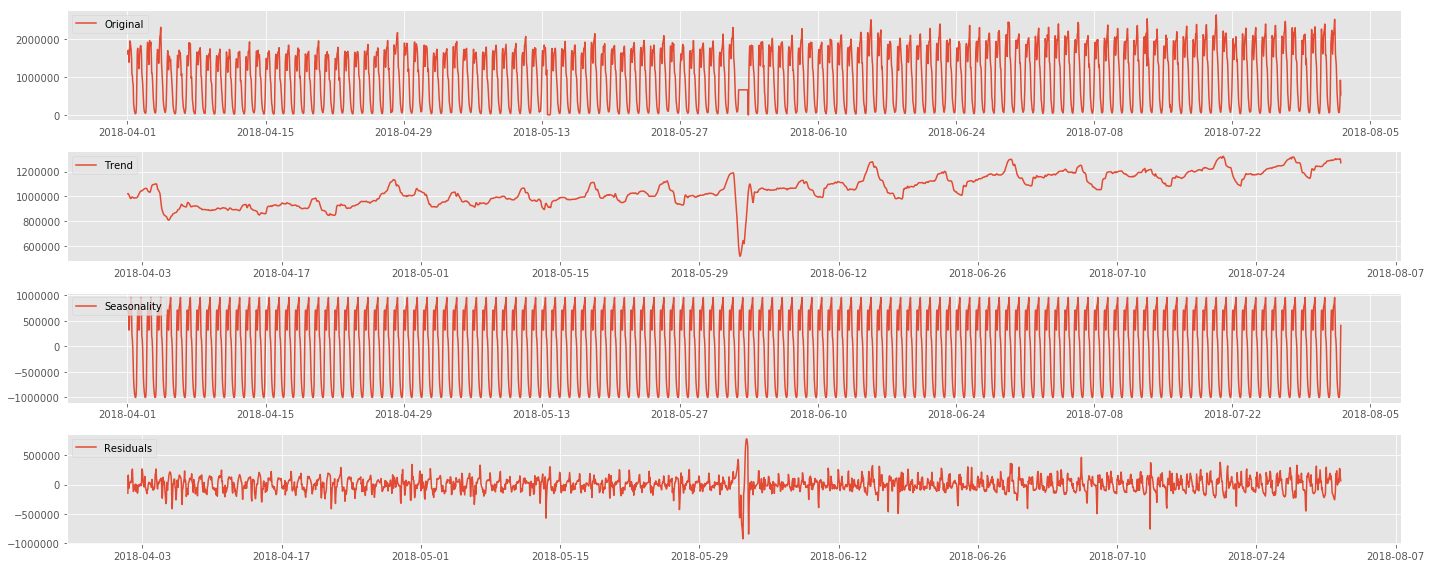

In [12]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_r)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(20,8))
plt.subplot(411)
plt.plot(ts_r, label='Original')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='upper left')
plt.tight_layout()

More formally, we can check stationarity by:  
* Plotting Rolling Statistics:   
We can plot the moving average or moving variance and see if it varies with time. By moving average/variance I mean that at any instant 鈥榯鈥�, we鈥檒l take the average/variance of the last month or last week. 
* Dickey-Fuller Test:   
This is one of the statistical tests for checking stationarity. Here the null hypothesis is that the TS is non-stationary. The test results comprise of a Test Statistic and some Critical Values for difference confidence levels. If the 鈥楾est Statistic鈥� is less than the 鈥楥ritical Value鈥�, we can reject the null hypothesis and say that the series is stationary. 

In [14]:
# Define function using the rolling statistics plots along with Dickey-Fuller test results
# In our case let's set the time window as one weeks (168 hours)
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=168,center=False).mean()
    rolstd =timeseries.rolling(window=168,center=False).std()

    #Plot rolling statistics:
    plt.figure(figsize=(16,4))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

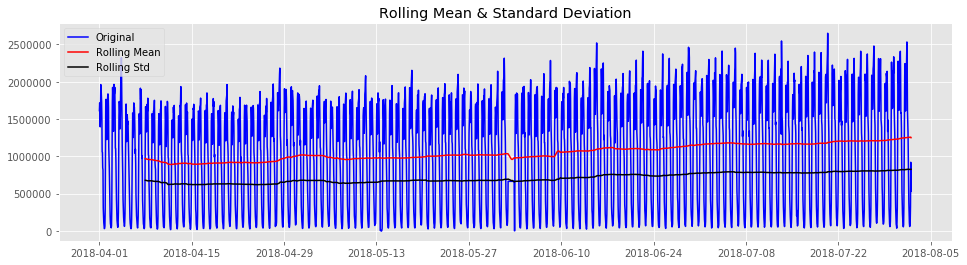

Results of Dickey-Fuller Test:
Test Statistic                   -4.864249
p-value                           0.000041
#Lags Used                       28.000000
Number of Observations Used    2923.000000
Critical Value (1%)              -3.432589
Critical Value (5%)              -2.862529
Critical Value (10%)             -2.567297
dtype: float64


In [15]:
test_stationarity(ts_r)

From the visualization we can see the variation is small and the line looks very smooth, the mean is quite smooth as well.     
It turns out our judgement is correct by the DF-test result, because the test statistic is smaller than the critical values (Note that the signed values should be compared and not the absolute values).

### Short conclusion: 
From statistic perspective, the Telelog data can be regarded as "Stationary", so we will not do addtional improvements on the data. 

## Step 4 - ARIMA Time Series Model
How to choose forecasting models? please refer: https://people.duke.edu/~rnau/411fcst.htm  
In this case we are going to use ARIMA as our forecasting model, more details for ARIMA please refer: https://people.duke.edu/~rnau/411arim.htm  



## Step 5 - Parameter Selection for the ARIMA Time Series Model

We will use a "grid search" to iteratively explore different combinations of parameters. For each combination of parameters, we fit a new seasonal ARIMA model with the SARIMAX() function from the statsmodels module and assess its overall quality. Once we have explored the entire landscape of parameters, our optimal set of parameters will be the one that yields the best performance for our criteria of interest.  
This idea is inspired by https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-arima-in-python-3

In [16]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 24) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 24)
SARIMAX: (0, 0, 1) x (0, 1, 0, 24)
SARIMAX: (0, 1, 0) x (0, 1, 1, 24)
SARIMAX: (0, 1, 0) x (1, 0, 0, 24)


We will use the AIC (Akaike Information Criterion) value, which is conveniently returned with ARIMA models fitted using statsmodels. The AIC measures how well a model fits the data while taking into account the overall complexity of the model. We are interested in finding the model that yields the lowest AIC value.

In [21]:
import warnings
warnings.filterwarnings("ignore") # specify to ignore warning messages

AIC = []
SARIMAX = []
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(ts_r,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()

            print('ARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))           
            AIC.append(results.aic)
            SARIMAX.append([param, param_seasonal])           
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 1, 24) - AIC:88627.9175919382
ARIMA(0, 0, 0)x(0, 1, 1, 24) - AIC:77717.99585021262
ARIMA(0, 0, 0)x(1, 0, 0, 24) - AIC:79136.98634844003
ARIMA(0, 0, 0)x(1, 0, 1, 24) - AIC:78600.23881863336
ARIMA(0, 0, 0)x(1, 1, 0, 24) - AIC:78027.58916752273
ARIMA(0, 0, 0)x(1, 1, 1, 24) - AIC:77694.47786971362
ARIMA(0, 0, 1)x(0, 0, 0, 24) - AIC:89049.547697687
ARIMA(0, 0, 1)x(0, 0, 1, 24) - AIC:87767.39450380448
ARIMA(0, 0, 1)x(0, 1, 0, 24) - AIC:77626.2109371965
ARIMA(0, 0, 1)x(0, 1, 1, 24) - AIC:76361.33958978139
ARIMA(0, 0, 1)x(1, 0, 0, 24) - AIC:87519.91354273044
ARIMA(0, 0, 1)x(1, 0, 1, 24) - AIC:87454.60949521947
ARIMA(0, 0, 1)x(1, 1, 0, 24) - AIC:76648.64467906186
ARIMA(0, 0, 1)x(1, 1, 1, 24) - AIC:76363.13920689837
ARIMA(0, 1, 0)x(0, 0, 1, 24) - AIC:80102.11132686034
ARIMA(0, 1, 0)x(0, 1, 1, 24) - AIC:75443.40959658609
ARIMA(0, 1, 0)x(1, 0, 0, 24) - AIC:77084.63342157903
ARIMA(0, 1, 0)x(1, 0, 1, 24) - AIC:76124.8377303511
ARIMA(0, 1, 0)x(1, 1, 0, 24) - AIC:76138.1095381437

The params with lowest AIC value will be used for training our model in next steps

In [24]:
print('The lowest AIC is {} for model SARIMAX{}x{}'.format(min(AIC), 
                                                             SARIMAX[AIC.index(min(AIC))][0],
                                                             SARIMAX[AIC.index(min(AIC))][1]))

The lowest AIC is 75338.15020419465 for model SARIMAX(1, 0, 1)x(1, 1, 1, 24)


## Step 6 - Fitting an ARIMA Time Series Model
More optional params please refer http://www.statsmodels.org/stable/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html 

In [29]:
mod = sm.tsa.statespace.SARIMAX(ts_r,
                                order=SARIMAX[AIC.index(min(AIC))][0],
                                seasonal_order=SARIMAX[AIC.index(min(AIC))][1],
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7487      0.012     61.069      0.000       0.725       0.773
ma.L1          0.0661      0.017      3.898      0.000       0.033       0.099
ar.S.L24       0.0675      0.022      3.063      0.002       0.024       0.111
ma.S.L24      -0.7307      0.011    -65.387      0.000      -0.753      -0.709
sigma2      1.479e+10   3.21e-13   4.61e+22      0.000    1.48e+10    1.48e+10


The coef column shows the weight (i.e. importance) of each feature and how each one impacts the time series.   
The P>|z| column informs us of the significance of each feature weight. 

When fitting seasonal ARIMA models, it is important to run model diagnostics to ensure that none of the assumptions made by the model have been violated. The plot_diagnostics object allows us to quickly generate model diagnostics and investigate for any unusual behavior.

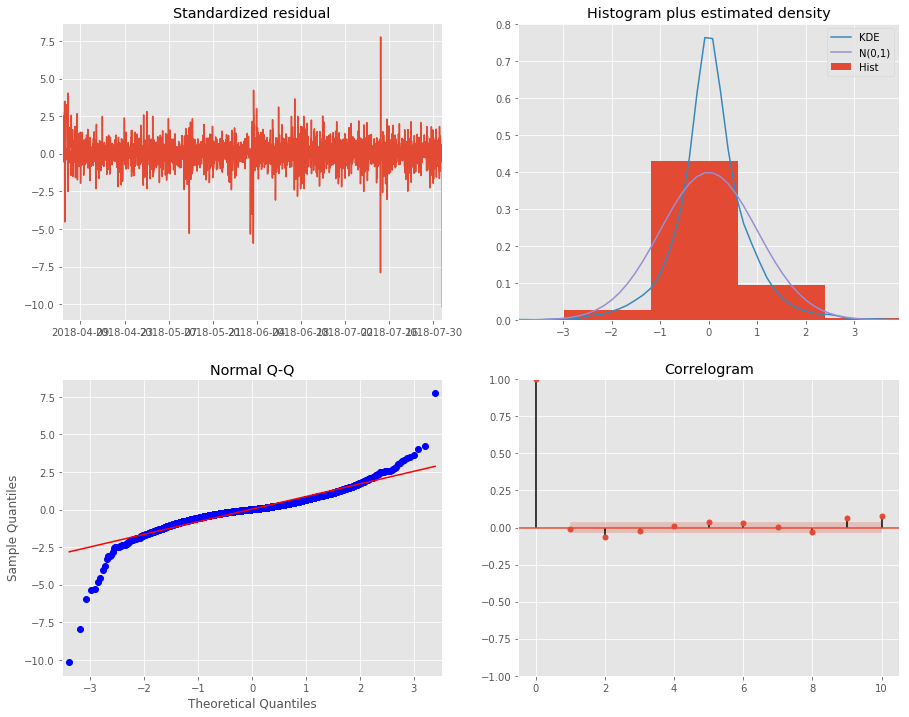

In [30]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In the plots we can see that the residuals are basically not uncorrelated (bottom right plot). Also, the residuals and roughly normally distributed with zero mean (top right plot). The qq-plot on the bottom left shows that the ordered distribution of residuals (blue dots) roghly follows the linear trend of samples taken from a standard normal distribution with N(0, 1). Basically the residuals can be regarded as normally distributed.

## Step 7 - Validating Forecasts

In [35]:
# Obtain the values and associated confidence intervals for forecasts of the time series.
pred = results.get_prediction(start=pd.to_datetime('2018-07-26 01:00:00'), dynamic=False)
pred_ci = pred.conf_int()

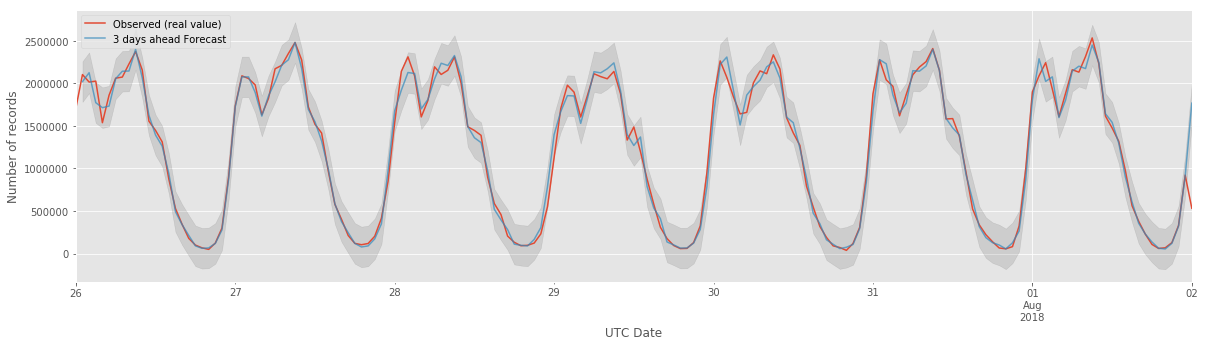

In [37]:
plt.figure(figsize=(20,5))
ax = ts_r['2018-07-26':].plot(label='Observed (real value)')
pred.predicted_mean.plot(ax=ax, label='3 days ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.1)

ax.set_xlabel('UTC Date')
ax.set_ylabel('Number of records')
plt.legend()
plt.show()

### Quantifing the accuracy
The forecast looks good, but we still need to quantify the accuracy of our forecasts. The benifits are: 
* As a single value Metric to fine tuning our model 
* Will be a reference for labeling our email notification level (INFO, WARNING, or ERROR) 

We will first use MSE (Mean Squared Error):

In [45]:
y_forecasted = pred.predicted_mean
y_truth = ts_r['2018-07-26 01:00:00':] # predict last three days only for demostration

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The MSE of our forecasts is {}'.format(round(mse)))

The MSE of our forecasts is 16997007994


MSE is an absolute metric, therefore scale-dependent. Considering the absolute value of MSE is pretty big, it would be better to introduce a commonly-used percentage error measure: Mean Absolute Percentage Error (MAPE)

In [39]:
# Compute the Mean Absolute Percentage Error
mape = np.mean(np.abs((y_truth - y_forecasted) / y_truth)) * 100
print('The MAPE of our forecasts is {:.2f}%'.format(mape))

The MAPE of our forecasts is 10.29%


### Re-plot with forecasts

## Step 8 - Fine tuning the model
We will fine tuning our model based on a series of questions

### Quetion 1: How long do we need the data to train our model?
A: We were using full data to train the model, the performance looks good. now let's use the same approach to re-train the model based on the data of one month/two week/one week, and finally decide which is suitable.  
To avoid copy/past the same code here, we will test it in separated notebooks (`arima_1m.ipynb, arima_2w.ipynb, arima_1w.ipynb`)  
* Full data -> MSE: 27.99  
* One month -> MSE: 30.22  
* two weeks -> MSE: 31.87  
* One week -> MSE: 32.76  

We decided to use last One Month data to train the model. 


### Question 2: The forecast for Number of session, and Number of vins? 
A: we will do that in separated notebooks as well (`arima_session.ipynb, arima_vin.ipynb`)   
The performance is quite similar to the forecast of Number of records, the major difference is the parameter combination: 
* Number of records: ARIMA(1, 1, 1)x(0, 1, 1, 24)   
* Number of sessions: ARIMA(1, 0, 1)x(1, 1, 1, 24)   
* Number of vins: ARIMA(1, 1, 1)x(0, 1, 1, 24)   